<h1>LAB 3 - Tarek Halsaka and Francesco Brusca<h1>

<h3> Part 1 <h3>

Image Shape: (180, 112, 3)
Image Shape: (90, 56, 3)
Image Shape: (45, 28, 3)


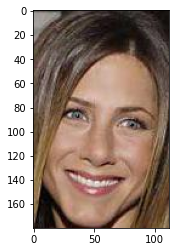

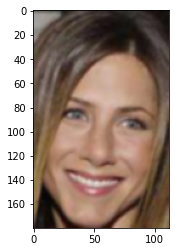

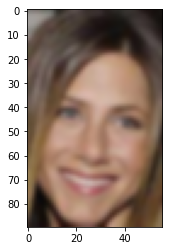

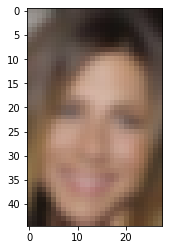

In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import imutils
import os
import math
import pickle


imgFile = 'face.jpg'
chdir=""
ann= []
all_image_path=[]
fullPath=[]
boxa=[]
annotation_path = "FDDB/FDDB-folds/"
iou=[]
numimgexclude=0 
allbackround=[]
allfaces=[]
imgExcludelist=[]
# %%


def alg_pyramid(image, minSize=(16, 16)):
    pyramid = []
    sigma = 1
    #first level
    image = cv2.GaussianBlur(image, (7,7), sigma)

    pyramid.append(image)
    while True: #while  removing n_level
        sigma=1
        image = cv2.GaussianBlur(image, (7,7), sigma)
        sigma = sigma*np.sqrt(2)
        image = cv2.GaussianBlur(image, (9,9), sigma)
        w = int(image.shape[1] /2)
        h = int(image.shape[0] /2)
        image = imutils.resize(image, width=w, height=h)
        #image = cv2.resize(image, (image.shape[0]/2, image.shape[1]/2), interpolation= cv2.INTER_NEAREST)
        #image = image[::2,::2] #downsampling S_2
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        pyramid.append(image)

            
    return pyramid



image = cv2.imread(imgFile)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(image)
pyramid = alg_pyramid(image=image)
for i in range(len(pyramid)):
    print("Image Shape: {}".format(pyramid[i].shape))
    plt.figure()
    plt.imshow(pyramid[i])

In [2]:
#impulse response.......

<h3> Part 2 <h3>

In [3]:
#functions built in previous homeworks..

In [4]:
def readTextFile(path):
    list_of_files =sorted(os.listdir("./FDDB/FDDB-folds/"))

    for index, file in enumerate(list_of_files):
    #READ ALL THE ANNOTATION FILE AND STOR IT IN ONE LIST
        if index % 2 == 0:
            with open(annotation_path+list_of_files[index]) as ff:
                for xx in ff: 
                    ann.append(xx.rstrip())
        else:
            with open(annotation_path+list_of_files[index]) as f:
                for xx in f:
                    all_image_path.append(xx.rstrip())

    return all_image_path,ann


def parseAnnotation(image_path,annotationList):
    faces=[]

    image_Full_path= "./FDDB/originalPics/"+ image_path.strip()+".jpg"
    if image_path in annotationList:
        index=annotationList.index(image_path)
        numOfFace= int(annotationList[index+1])
        index=index+2
    for i in range(numOfFace):
        faces.append(annotationList[index].rstrip())
        index=index+1
    return  faces, numOfFace, image_Full_path

def crop_face(image_path,faces,numberOfFaceInImage):
    '''
    this function take 
    
    image path: to read image
    faces : annotation of ellips 
    numberOfFaceInImage: number of face inside the image
                            to drow ellipce or exracted the face 
    return: the face image crop it from the image
            and left top right bottom of the image 
    '''
    img= cv2.imread(image_path)  
    crop_faces = []
    coord_crop_faces = []
    for i in range(numberOfFaceInImage):
        axis_radius1, axis_radius2, angle, center_x, center_y, _ = faces[i].split()
        axis_radius1= float(axis_radius1)
        axis_radius2= float(axis_radius2)
       
        
        major_axis = int(max(axis_radius1, axis_radius2))
        minor_axis = int(min(axis_radius1, axis_radius2))
        angle = int(math.degrees(float(angle))) 
        center_x, center_y = int(float(center_x)), int(float(center_y))
        
        temp_crop_face = img[check(center_y-major_axis):check(center_y+major_axis), check(center_x-minor_axis):check(center_x+minor_axis)]
        crop_faces.append(temp_crop_face)
        temp_coord_crop_face = check(center_x-minor_axis), check(center_y-major_axis), check(center_x+minor_axis), check(center_y+major_axis)
        coord_crop_faces.append(temp_coord_crop_face)
       
    return crop_faces, coord_crop_faces 

def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou
def check(value):
    if value < 0:
        value = 0
    return value

In [5]:
#sliding window function
def sliding_window(image, stepSize, windowSize):
    for y in range(0, image.shape[0]-windowSize[0], stepSize):
        for x in range(0, image.shape[1]-windowSize[1], stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

#usefull function to check if the division is possible or not
#this function is used in the calculation of precision,recall adn F1score
def check_division_by0(num, den):
    try:
        z = num / den
    except ZeroDivisionError:
        z = 0
    return z

In [6]:
#importing the model trained in lab2
from tensorflow.keras.models import load_model
# load model
model = load_model('my_model_trained.h5')
# summarize model.
model.summary()

C:\Users\franc\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\franc\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\franc\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\franc\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               98560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 34        
Total para

In [7]:
run_algorithm= False
if run_algorithm:
    
    Window_size = [16,19,23,28,33,40,48,57,69,83,99]
    time_window = []
    precision_evolution = []
    recall_evolution = []
    F1score_evolution =  []
    start = time.time()
    for w in Window_size:
        
        image_path, ann= readTextFile(annotation_path)
        choose_image_to_work_on=image_path
        precision_window = []
        recall_window = []
        F1score_window = []
        for index,path_list in enumerate(choose_image_to_work_on): #iteration over the images
            if index % 50 == 0:
                print("image I work on ",index)
            faces, numFace,fullPath= parseAnnotation(path_list,ann)
            tmp_img = cv2.imread(fullPath)
            tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_RGB2GRAY) # put image in gray scale bc the network is trained in gray scale
    #        plt.figure()
    #        plt.imshow(tmp_img, cmap='gray') 
           
            #next reshaping is to add the channel value (1)
            tmp_img = tmp_img.reshape(tmp_img.shape[0], tmp_img.shape[1],1)
            
            
            crop_faces, coord_crop_faces = crop_face(fullPath,faces,numFace)
            
            dict_faces = {}   #initialization of a dictionary to understand which and how many faces will be recognised 
            for i in range(len(faces)):
                dict_faces[i] = 0
                
        #    print('inizializzazione del dizionario:', dict_faces)
            
            windowSize = w
            TP = 0 #true positive
            FP = 0 #false positive
            TN = 0 #true negative
            FN = 0 #false negative
            n_detected_faces = 0
            detected_faces = []
            crop_faces_corresponding = []
            false_negative = []
            missing_face = 0
            for (x, y, window) in sliding_window(tmp_img, stepSize=int(windowSize/2), windowSize=(windowSize,windowSize)):
                #reshaping the window for go in the network..
                window = cv2.resize(window, (24,16))
                window = window.reshape(1, window.shape[0], window.shape[1], 1)
                y_pred = model.predict(window)
                y_pred = np.argmax(y_pred, axis=1)
        #        n_faces = 0
                
                '''
                    TRUE POSITIVE: 
                        window detect a face (y_pred == 0) and was a face (iou > 0.5)
                    FALSE POSITIVE:
                        window detect a face (y_pred == 0) and was not a face (iou < 0.5)
                    TRUE NEGATIVE: 
                        window detect a background (y_pred == 1) and was a background (iou < 0.5)
                    FALSE NEGATIVE: 
                        window detect a background (y_pred == 1) and was a face (iou > 0.5)
                '''
                window_coord = x,y,x + windowSize, y + windowSize
        
                if (y_pred == 0): #the model predict that in the window there is a face
                    for i in range(len(coord_crop_faces)):
                        iou = bb_intersection_over_union(coord_crop_faces[i], window_coord)
                        if iou > 0.5: #true positive
                            TP +=1
                            #distinguere le facce!!!!!!!!!
                            if dict_faces[i] == 0: #the face reconised from the model is memorized if before wasn't
    #                            print('trovata una')
                                dict_faces[i] = 1
    #                            n_detected_faces += 1
    #                            detected_faces.append(window)
    #                            crop_faces_corresponding.append(crop_faces[i])
                            #in case not if that face was already recognised
        
                        else:         #false positive
                            FP +=1
                else: #y_pred==1, the model predict that in the window there is a background
                    for i in range(len(coord_crop_faces)):
                        iou = bb_intersection_over_union(coord_crop_faces[i], window_coord)
                        if iou > 0.5: #false negative
                            FN +=1
    #                        false_negative.append(window)
    #                        missing_face +=1
                        else:         #true negative
                            TN +=1
    #        print('the number of the faces in the original image was ', numFace)
    #        print('the model found ', n_detected_faces, ' faces')
    #    
    #        print('the faces detected were:')
    #        for i in range(len(detected_faces)):
    #            plt.figure()
    #            plt.imshow(np.squeeze(detected_faces[i]), cmap='gray')
    #            plt.figure()
    #            plt.imshow(crop_faces_corresponding[i], cmap ='gray')
    #           
    #        print(TP)
    #        print(FP)
    #        print(TN)
    #        print(FN)
            #  Report precision, recall, F1 and
            precision_tmp_img = check_division_by0(TP,(TP+FP))
            recall_tmp_img = check_division_by0(TP,(TP+FN))
            F1score_tmp_img = check_division_by0((2*(precision_tmp_img*recall_tmp_img)),(precision_tmp_img+recall_tmp_img))
            precision_window.append(precision_tmp_img)
            recall_window.append(recall_tmp_img)
            F1score_window.append(F1score_tmp_img)
            
        precision_evolution.append(np.mean(precision_window))  
        recall_evolution.append(np.mean(recall_window))
        F1score_evolution.append(np.mean(F1score_window))
    time_window.append(time.time()-start)

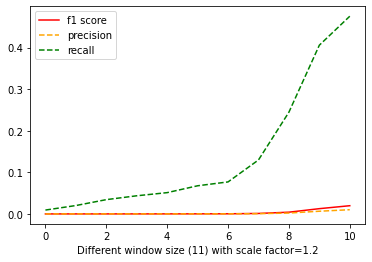

In [8]:
with open("F1score_evolution_Ex2.txt", "rb") as fp:   # Unpickling
    F1score_evolution_Ex2 = pickle.load(fp)   
with open("precision_evolution_Ex2.txt", "rb") as fp:   # Unpickling
    precision_evolution_Ex2 = pickle.load(fp)
with open("recall_evolution_Ex2.txt", "rb") as fp:   # Unpickling
    recall_evolution_Ex2 = pickle.load(fp)
 
plt.figure()
plt.plot(F1score_evolution_Ex2, 'r', label='f1 score' )
plt.plot(precision_evolution_Ex2, color='orange', linestyle='--', label= 'precision')
plt.plot(recall_evolution_Ex2, 'g--', label='recall')
plt.xlabel('Different window size (11) with scale factor=1.2')
plt.legend()

<h3> Part 3 <h3>

In [9]:
#for this part we used the same code of the second one, but we iterated also over the various pramids

In [10]:
run_algorithm= False
if run_algorithm:
    
    Window_size = [16,19,23,28,33,40,48,57,69,83,99]
    time_window = []
    precision_evolution = []
    recall_evolution = []
    F1score_evolution =  []
    start = time.time()
    for w in Window_size[0:5]:
        
        image_path, ann= readTextFile(annotation_path)
        choose_image_to_work_on=image_path
        
        precision_window = []
        recall_window = []
        F1score_window = []
        
        for index,path_list in enumerate(choose_image_to_work_on): #iteration over the images
            if index % 100 == 0:
                print("image I work on ",index)
            
            faces, numFace,fullPath= parseAnnotation(path_list,ann)
            tmp_img = cv2.imread(fullPath)
            tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_RGB2GRAY) # put image in gray scale bc the network is trained in gray scale

            tmp_img = tmp_img.reshape(tmp_img.shape[0], tmp_img.shape[1],1)
            crop_faces, coord_crop_faces = crop_face(fullPath,faces,numFace)  

            windowSize = w
            TP = 0 #true positive
            FP = 0 #false positive
            TN = 0 #true negative
            FN = 0 #false negative
            n_detected_faces = 0
            detected_faces = []
            crop_faces_corresponding = []
            false_negative = []
            missing_face = 0
            
            precision_evolution_pyramid = []
            recall_evolution_pyramid = []
            F1score_evolution_pyramid = []
            
            list_img = alg_pyramid(tmp_img)
            
            for tmp_pyrimg in list_img:

                for (x, y, window) in sliding_window(tmp_pyrimg, stepSize=int(windowSize/2), windowSize=(windowSize,windowSize)):
                    #reshaping the window for go in the network..
                    window = cv2.resize(window, (24,16))
                    window = window.reshape(1, window.shape[0], window.shape[1], 1)
                    
                    y_pred = model.predict(window)
                    y_pred = np.argmax(y_pred, axis=1)
                    
                    '''
                        TRUE POSITIVE: 
                            window detect a face (y_pred == 0) and was a face (iou > 0.5)
                        FALSE POSITIVE:
                            window detect a face (y_pred == 0) and was not a face (iou < 0.5)
                        TRUE NEGATIVE: 
                            window detect a background (y_pred == 1) and was a background (iou < 0.5)
                        FALSE NEGATIVE: 
                            window detect a background (y_pred == 1) and was a face (iou > 0.5)
                    '''
                    window_coord = x,y,x + windowSize, y + windowSize
            
                    if (y_pred == 0): #the model predict that in the window there is a face
                        for i in range(len(coord_crop_faces)):
                            iou = bb_intersection_over_union(coord_crop_faces[i], window_coord)
                            if iou > 0.5: #true positive
                                TP +=1        
                            else:         #false positive
                                FP +=1
                    else: #y_pred==1, the model predict that in the window there is a background
                        for i in range(len(coord_crop_faces)):
                            iou = bb_intersection_over_union(coord_crop_faces[i], window_coord)
                            if iou > 0.5: #false negative
                                FN +=1
                            else:         #true negative
                                TN +=1

            #  Report precision, recall, F1 and
                    precision_tmp_pyr = check_division_by0(TP,(TP+FP))
                    recall_tmp_pyr = check_division_by0(TP,(TP+FN))
                    F1score_tmp_pyr = check_division_by0((2*(precision_tmp_pyr*recall_tmp_pyr)),
                                                                        (precision_tmp_pyr+recall_tmp_pyr))
                    precision_evolution_pyramid.append(precision_tmp_pyr)
                    recall_evolution_pyramid.append(recall_tmp_pyr)
                    F1score_evolution_pyramid.append(F1score_tmp_pyr)
                
                
            
            precision_tmp_img = np.mean(precision_evolution_pyramid)
            recall_tmp_img = np.mean(recall_evolution_pyramid)
            F1score_tmp_img = np.mean(F1score_evolution_pyramid)
            
            precision_window.append(precision_tmp_img)
            recall_window.append(recall_tmp_img)
            F1score_window.append(F1score_tmp_img)
            
        precision_evolution.append(np.mean(precision_window))  
        recall_evolution.append(np.mean(recall_window))
        F1score_evolution.append(np.mean(F1score_window))
    time_window.append(time.time()-start)

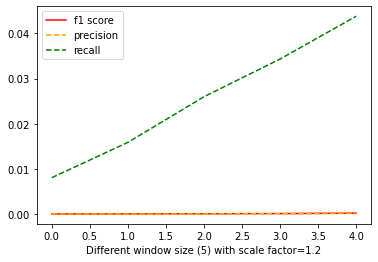

In [11]:
with open("F1score_evolution_Ex3.txt", "rb") as fp:   # Unpickling
    F1score_evolution_Ex3 = pickle.load(fp)   
with open("precision_evolution_Ex3.txt", "rb") as fp:   # Unpickling
    precision_evolution_Ex3 = pickle.load(fp)
with open("recall_evolution_Ex3.txt", "rb") as fp:   # Unpickling
    recall_evolution_Ex3 = pickle.load(fp)

plt.figure()
plt.plot(F1score_evolution_Ex3, 'r', label='f1 score' )
plt.plot(precision_evolution_Ex3, color='orange', linestyle='--', label= 'precision')
plt.plot(recall_evolution_Ex3, 'g--', label='recall')
plt.xlabel('Different window size (5) with scale factor=1.2')
plt.legend()

